In [373]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import math
from scipy.sparse.linalg import spsolve
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=400,precision=10,suppress=True)

# Partie 1: GMRES

# Question 1:

In [374]:
def Arnoldi(A,V,H):
    
    k=V.shape[1]
    n=A.shape[0]
    
    Vp = np.zeros((n,k+1)).astype(np.float64)
    Hp = np.zeros((k+1,k)).astype(np.float64)
    Wk = np.zeros((n,1)).astype(np.float64) #un vecteur pour calculer vk et h(k,k-1)
    
    Vp[:,0:-1] =  V[:,:] 
    Hp[0:-1,0:-1] =  H[:,:] 
    
    """calcul de h(j,k-1)->Hp(j,k-1), j=[0,k-1]"""
    for i in range(k):
        Hp[i,-1] = np.dot(A@V[:,-1],V[:,i])
        
    #print("check=",Hp[:,:]) 
    
    """calcule de Wk"""
    Wk[:,-1]=A@V[:,-1]
    for i in range(k):
        Wk[:,-1] -= np.dot(A@V[:,-1],V[:,i])*V[:,i]
        
    #print("check=",Wk[:,-1])
    
    """calcul de vk"""
    Vp[:,-1] = Wk[:,-1]/sp.linalg.norm(Wk[:,-1])
    
    #print("check=",Vp[:,-1])
    
    """calcul de h(k,k-1)->Hp"""
    Hp[-1,-1] = sp.linalg.norm(Wk[:,-1]) 
    
    #print("check=",Hp[:,-1])
      
    return Vp,Hp     

In [375]:
"""test"""
def Arnoldi_test(n,k):
    A = np.ones((n,n)) 
    V=np.ones((n,k))
    H=np.ones((k,k-1))
    Vp,Hp = Arnoldi(A,V,H)
    print("Vp = \n",Vp)
    print("Hp = \n",Hp)
    return Vp,Hp
    
Vp,Hp = Arnoldi_test(4,3)

Vp = 
 [[ 1.   1.   1.  -0.5]
 [ 1.   1.   1.  -0.5]
 [ 1.   1.   1.  -0.5]
 [ 1.   1.   1.  -0.5]]
Hp = 
 [[ 1.  1. 16.]
 [ 1.  1. 16.]
 [ 1.  1. 16.]
 [ 0.  0. 88.]]


# Question 2:

***Quelques notes:***

Il est à noter que dans les codes fournis ci-dessous aussi dans l'énoncé: $$ H= \hat {H_k} =H_p$$
Alors que dans le cours on a vue que:  $$ H= \hat {H}[:k+1,:k+1] =\hat {H}[0:-1,:] \in \mathbf M_{(k+1,k+1)}$$

Il est important de poser un vecteur numpy et préciser la forme (i.e. shape=(1,0)) au lieu d'une liste vide [] pour l'initialisation de $\hat H_{-1}$.

Il faut avoir les dimensions suivant:
$y\in \mathbf R^{k+1}$

$\hat H_{k} \in \mathbf M_{(k+2,k+1)}$

$ Q_{k} \in \mathbf O_{(k+2,k+2)}$

$ {\bar R}_{k} \in \mathbf M_{(k+1,k+1)}$

$ x_k \in \mathbf R^{n}$


In [376]:
"""pour eviter de calculer a chaque fois"""
eps=10**(-4)

***Nombre d'iterations:***

Pour éviter que GMRES tourne "longtemps" on pourai introduire un parametre optionnel "iter_limit" et on a ajouter une contrainte sur le nombre d'iteration dans la boucle while ci-dessous. Dans le cours on a montrer que $k="cpt"$ doit être << n donc on la rajoute comme condition d'arret (e.g. $k < n$). Il faut ajouter cette condition au cas ou la precision est trés haute (e.g $<< 1*10^{-10}$).

In [377]:
def gmres(A,b,xexact,eps = eps,iter_limit = True):
    
    """Initialisation"""
    cpt = 0 #pour calculer le nombre d'iteration
    n=A.shape[0]
    x0=np.zeros_like(b)# Remarque:si elle != 0 on doit l'accumuler pour calculer x_(k+1) = x_0 + V_k*y 
    print("\n------Solution pour k="+str(cpt)+"------\nx_0=\n",x0)
    r0 = b-A@x0
    v0= r0/sp.linalg.norm(r0)
    
    V = v0.reshape((n,1))
    H = np.array([]).reshape(1,0)
    
    err_rel = sp.linalg.norm(xexact-x0)/ sp.linalg.norm(xexact)
    res_rel = sp.linalg.norm(r0)/ sp.linalg.norm(r0)
    
    X = x0
    Err_rel = np.array([err_rel])
    Res_rel = np.array([res_rel])
    
    while (res_rel > eps):
        
        """On poura mettre une autre limite que n (e.g n/2 !?)"""
        if(iter_limit and (cpt>n)):
            X = X.reshape(int(len(X)/n),n)
            return X,Err_rel,Res_rel
        
        """calcul de V,H,Q et R"""
        V,H = Arnoldi(A,V,H)
        Q,R = sp.linalg.qr(H)
        """
        print("\nV=\n",V)
        print("\nH=\n",H)
        print("\nR=\n",R)
        print("\nQ=\n",Q)
        print("\nV=\n",V.shape)
        print("\nH=\n",H.shape)
        print("\nR=\n",R.shape)
        print("\nQ=\n",Q.shape)
        """
        """solve y tq R'y=Q'"""
        C= sp.linalg.norm(r0)*np.transpose(Q)[0:-1,0:1]#(k+1,1)
        #print("\nC=\n",C.shape)
        y = np.linalg.solve(R[0:-1,:],C) #(k+1,1)
        
        #print("y=\n",y.shape)
        
        x = V[:,0:-1]@y
        
        rk = b-A@x
        
        err_rel = sp.linalg.norm(xexact-x)/ sp.linalg.norm(xexact)
        res_rel = sp.linalg.norm(rk)/ sp.linalg.norm(r0)
        
        cpt+=1
        print("\n------Solution pour k="+str(cpt)+"------\nx_"+str(cpt)+"=\n",x.T)
        
        X = np.append(X,x)
        Err_rel = np.append(Err_rel,err_rel)
        Res_rel = np.append(Res_rel,res_rel)
        
    X = X.reshape(int(len(X)/n),n)
    return X,Err_rel,Res_rel

# Question 3:

***Remarque:***
Pour avoir une haute précision l'algo tourne en boucle sans avoir la precision recherché et ceci est peut être causé par les arrondi fait par la machine!? D'ou l'utilité du parametre optionnel `iter_limit` qu'il est recommender de mettre à `True`.

In [378]:
"""test"""
def GMRES_test(n):
    A= np.diag(2*np.ones(n)) + 0.5*np.random.rand(n,n)/np.sqrt(n)
    b =np.ones(A.shape[0])
    xexact = np.linalg.solve(A,b)
    
    """On pourra calculer b en se basant sur x pour a voir une valeur certaine de comparaison!"""
    """
    xexact =  np.ones(A.shape[0])
    b=A@xexact 
    """
    #X,Err_rel,Res_rel= gmres(A,b,xexact,iter_limit = False) #dans ce cas il faut réduire la précision eps
    X,Err_rel,Res_rel= gmres(A,b,xexact,iter_limit = True) #n iteration semble raisonnable!
    
    return xexact,X,Err_rel,Res_rel

In [379]:
n=10
xexact,X,Err_rel,Res_rel= GMRES_test(n)
print("\n \t \t  \t* -------------La solution exacte est------:*\n \t \t  \t Sol=\n \t \t  \t",xexact)


------Solution pour k=0------
x_0=
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

------Solution pour k=1------
x_1=
 [[0.3582918952 0.3582918952 0.3582918952 0.3582918952 0.3582918952 0.3582918952 0.3582918952 0.3582918952 0.3582918952 0.3582918952]]

------Solution pour k=2------
x_2=
 [[0.340228221  0.4267690448 0.3367192537 0.3651350477 0.3436764329 0.3365532556 0.3967854421 0.3469832913 0.3301379571 0.3743570408]]

------Solution pour k=3------
x_3=
 [[0.3414527592 0.4272861472 0.3330711667 0.3690326311 0.3463434496 0.3310505383 0.3938027121 0.3488811306 0.3302858408 0.3758798138]]

------Solution pour k=4------
x_4=
 [[0.3415965027 0.4273118583 0.3329952162 0.3693876203 0.3464194256 0.3311349951 0.3939058078 0.3488845012 0.3301343346 0.375340577 ]]

 	 	  	* -------------La solution exacte est------:*
 	 	  	 Sol=
 	 	  	 [0.3416322989 0.4273197247 0.3329850181 0.3693788063 0.3464061431 0.3311439403 0.3938924622 0.3488767032 0.3301275701 0.3753452325]


***Tracé de l'erreur et le résidu en fonction des itération:***

In [380]:
def plot_erreur_residu(Err_rel,Res_rel):
    it = len(Res_rel)
    iteration=np.arange(it)

    fig,ax = plt.subplots(2,1,figsize=(9,6),sharex=True)
    ax[0].set_title(r"L'erreur relative en echelle logarithmique")
    ax[0].plot(iteration, Err_rel, "o-");
    #ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[1].set_title(r" Le résidu en échelle logarithmique")
    ax[1].plot(iteration, Res_rel, "o-");
    ax[1].plot(iteration, eps*np.ones(it), "r--",label=" Précision ="+str(eps));# décommentez pour voir la precision
    #ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].legend();

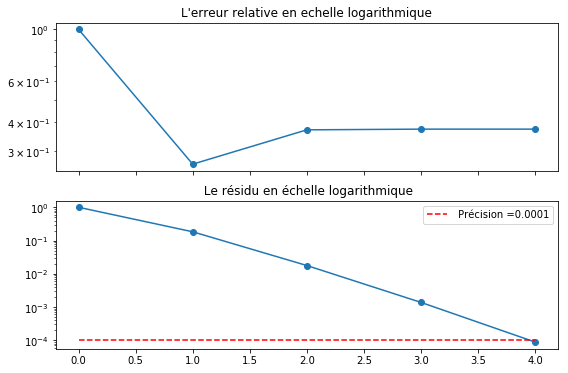

In [381]:
plot_erreur_residu(Err_rel,Res_rel)

***Commentaire:***

***Dans ce cas de n=10 GMRES converge au bout de 3 itération!***

# Question 4 (facultative):

In [382]:
def gmres_init(V,H):
    
    """Initialisation"""
    cpt = 0 #pour calculer le nombre d'iteration
    
    V = V[:,-2:-1]
    H = H[:,-1]
    
    return cpt,V,H
    

In [383]:
def gmres_p(A,b,xexact,p,eps = eps):
    
    """Initialisation"""
    cpt = 0 #pour calculer le nombre d'iteration
    n=A.shape[0]
    x0=np.zeros_like(b)
    print("\n------Solution pour k="+str(cpt)+"------\nx_0=\n",x0)
    r0 = b-A@x0
    v0= r0/sp.linalg.norm(r0)
    
    V = v0.reshape((n,1))
    H = np.array([]).reshape(1,0)
    
    err_rel = sp.linalg.norm(xexact-x0)/ sp.linalg.norm(xexact)
    res_rel = sp.linalg.norm(r0)/ sp.linalg.norm(r0)
    
    X = x0
    Err_rel = np.array([err_rel])
    Res_rel = np.array([res_rel])
    
    while (res_rel > eps):
        
        if(cpt>p):
            cpt,V,H =gmres_init(V,H)
        
        """calcul de V,H,Q et R"""
        V,H = Arnoldi(A,V,H)
        Q,R = sp.linalg.qr(H)
       
        """solve y tq R'y=Q'"""
        C= sp.linalg.norm(r0)*np.transpose(Q)[0:-1,0:1]#(k+1,1)
        #print("\nC=\n",C.shape)
        y = np.linalg.solve(R[0:-1,:],C) #(k+1,1)
        
        #print("y=\n",y.shape)
        
        x = V[:,0:-1]@y
        
        rk = b-A@x
        
        err_rel = sp.linalg.norm(xexact-x)/ sp.linalg.norm(xexact)
        res_rel = sp.linalg.norm(rk)/ sp.linalg.norm(r0)
        
        cpt+=1
        print("\n------Solution pour k="+str(cpt)+"------\nx_"+str(cpt)+"=\n",x.T)
        
        X = np.append(X,x)
        Err_rel = np.append(Err_rel,err_rel)
        Res_rel = np.append(Res_rel,res_rel)
        
        
    return X,Err_rel,Res_rel

Faute de temps la fonction ci-dessus n'est pas testée!!

# Partie 2: Gradient Conjugué

## Question 5:

***Complexité:***
On a vue dans le cours que l'algorithme du `gradient conjugué` converge au plus dans n étapes. On introduit dans l'algo ci-dessous une condition d'arret supplémentaire telle que cpt < n pour éviter des boucle du au arrodis de la machine.

In [386]:
def gradient_conjugue(A,b,xexact,eps=eps):
     
    """Initialisation"""
    cpt = 0 #pour calculer le nombre d'iteration
    n=A.shape[0]
    x=np.zeros_like(b)
    #print("\n------Solution initiale--------\nx_0=\n",x)
    r0 = b-A@x # pour eviter d'avoir des copie de pointeur
    #print("check=",r0)
    d = b-A@x # pour eviter d'avoir des copie de pointeur
    r = b-A@x # pour eviter d'avoir des copie de pointeur
    
    err_rel = sp.linalg.norm(xexact-x)/ sp.linalg.norm(xexact)
    res_rel = sp.linalg.norm(r0)/ sp.linalg.norm(r0)
    
    Err_rel = np.array([err_rel])
    Res_rel = np.array([res_rel])
    
    #on pourra essayer pour while((res_rel > eps)and (cpt<n*n)) mais le résultat et pareil!
    while ((res_rel > eps)and (cpt<n)):
        
        """etape k"""
        r_k = r #pour pouvoir l'utiliser ultérieurement en bas
        
        """etape k+1"""
        s = (r@r)/((A@d)@d)
        x += s*d
        
        r -= s*A@d
        #print("check",sp.linalg.norm(r))
        
        beta = (r@r)/(r_k@r_k)
        d = r + beta*d 
        
        err_rel = sp.linalg.norm(xexact-x)/ sp.linalg.norm(xexact) 
        res_rel = sp.linalg.norm(r_k)/ sp.linalg.norm(r0)
        #print("check",sp.linalg.norm(r0))
        
        cpt+=1
        #print("\n------Solution pour k="+str(cpt)+"------\nx_"+str(cpt)+"=\n",x.T)
        
        Err_rel = np.append(Err_rel,err_rel)
        Res_rel = np.append(Res_rel,res_rel)
    print("\n------Solution obtenue aprés k="+str(cpt)+" iterations------\n \n")
   
    return x,Err_rel,Res_rel

## Question 6:

In [466]:
"""test"""
def gradient_conjugue_test(d):
    
    n = d*d
    A= spsp.diags([[4.]*n,[-1]*(n-1),[-1]*(n-1),[-1]*(n-d),[-1]*(n-d)],
                  [0,1,-1,d,-d])
    A = spsp.csr_matrix(A) #to.csr() n'a pas marché même dans le TP d'avant
    b =  2*np.ones(n).astype(np.float64)
    """solution exacte scipy"""
    xexact = np.array(spsolve(A,b))
    
    #print(xexact) 
    
    return A,b,xexact
d=3
A,b,xexact = gradient_conjugue_test(d)

In [388]:
%%time
x,Err_rel,Res_rel= gradient_conjugue(A,b,xexact)
print("* -------------La solution exacte est------:*\n \t \t  \t Sol=\n",xexact)
print("\n \n* -------------La solution trouvée est------:*\n \t \t  \t Sol_algo=\n",x)


------Solution obtenue aprés k=9 iterations------
 

* -------------La solution exacte est------:*
 	 	  	 Sol=
 [1.9096385542 2.4819277108 2.6987951807 3.156626506  3.3192771084 3.156626506  2.6987951807 2.4819277108 1.9096385542]

 
* -------------La solution trouvée est------:*
 	 	  	 Sol_algo=
 [2.0386599353 2.7233219148 2.9027527553 3.4960299732 3.6685363625 3.4960299732 2.9027527553 2.7233219148 2.0386599353]
Wall time: 7 ms


***Tracé de l'erreur et du residu:***

In [389]:
print("\n------L'erreur relative pour chaque iteration=------=\n",Err_rel)
print("\n------Le residus relatif pour chaque iteration=------=\n",Res_rel)


------L'erreur relative pour chaque iteration=------=
 [1.           0.232793935  0.059808932  0.0713859275 0.0807141612 0.0865666198 0.090119369  0.092351213  0.0938148622 0.0948088556]

------Le residus relatif pour chaque iteration=------=
 [1.           0.8291561976 0.2798153124 0.2513001507 0.2192648975 0.1927596676 0.1728531975 0.1580772837 0.1469753088 0.1385065383]


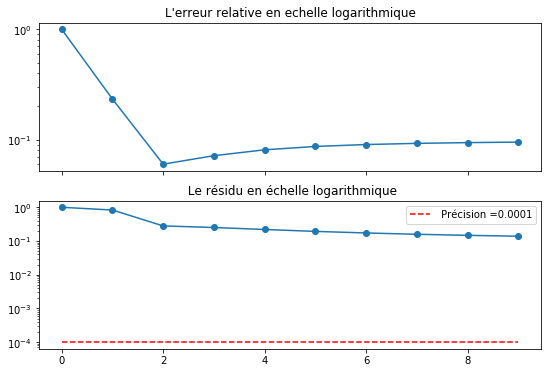

In [390]:
plot_erreur_residu(Err_rel,Res_rel)

***Commentaire:***
L'algorithme `Gradient conjugué` converge vers une solution avec un résidu relatif de $ \sim 10^{-1}$ à la 9 ème itération. Ceci est du au faite que la solution exact n'est pas bien estimée. On a essayé en augmentant le nombre d'itération maximal à $n*n$ mais la conclusion est pareil.

***Comparaison avec GMRES:***

Pour comparer les deux algorithmes on va résoudre la même équation et on va tracer les erreurs relative et les résidus de chaqu'un des algoritmes. En même temps on va comparer le temps de calcul grace à la commande ipython `%%time`.

In [391]:
"""Comparaison"""
def Comparaison(d):
    n = d*d
    B= spsp.diags([[4.]*n,[-1]*(n-1),[-1]*(n-1),[-1]*(n-d),[-1]*(n-d)],
                  [0,1,-1,d,-d])
    B = spsp.csr_matrix(B)
    b =  2*np.ones(n)
    """solution exacte scipy"""
    xexact = np.array(spsolve(B,b))
    A = np.array(B.toarray())
    
    return A,B,b,xexact
#d=3
d=10
A,B,b,xexact = Comparaison(d) #A sans stockage creux et B pour le stockage creux CSR 

In [392]:
%%time
x,Err_rel,Res_rel= gradient_conjugue(B,b,xexact)


------Solution obtenue aprés k=100 iterations------
 

Wall time: 45 ms


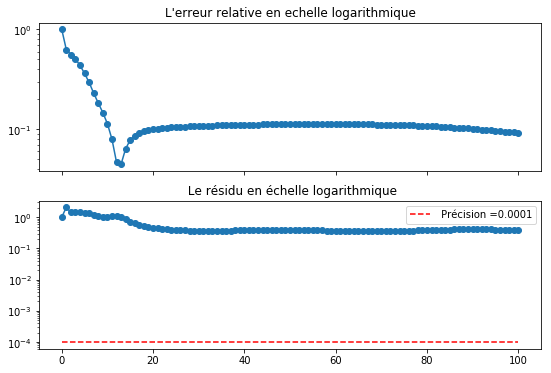

In [393]:
plot_erreur_residu(Err_rel,Res_rel)

In [394]:
%%time
X,Err_rel,Res_rel= gmres(A,b,xexact);


------Solution pour k=0------
x_0=
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

------Solution pour k=1------
x_1=
 [[1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923
  1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076923 1.6923076

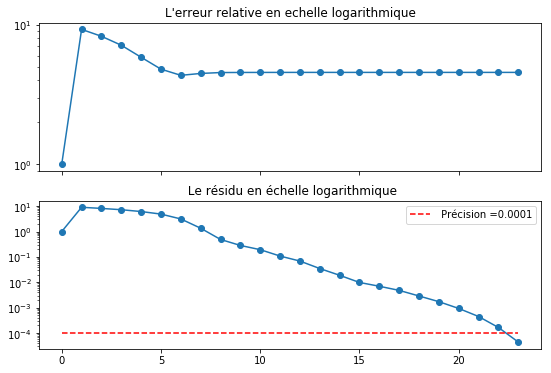

In [395]:
plot_erreur_residu(Err_rel,Res_rel)

***Conclusion de la comparaison:***

En utilisant la commande $%%time$ on a trouvé que le temps de calcule est quasi similaire en utilisant le `gradient conjugué` et le `GMRES` comme illustré dans le tableau suivant:

$$Pour: \, \, \, n= 9$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Algo} & GMRES&Gradient \, Conjugue \\
\hline
\text{Temps (ms)} & 14&7 \\
\hline
\end{array}
$$
***Quand n assez petit***
Les deux méthodes sont rapide avec un léger avantage pour `GMRES` pour la précision. Le `Gradient Conjugué` a pris dans cette exemple 2 à 3 itérations tandis que `GMRES` a mis pareil pour avoir le meme resultat et 3 autre pour ameliorer la précision . Ceci est justifié par la complexité vue en cours qui est $ << n$ pour `GMRES` et $ <n $ pour le `Gradient Conjugué`. Cependant dans le cas de matirices $S^{++}(\mathbb C)$ le `Gradient Conjugué` est recommendé.

On pourra également vérifier ceci dans le cas de n = 100 et la notion de temps est encore plus visible:

$$Pour: \, \, \, n= 100$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Algo} & GMRES&Gradient \, Conjugue \\
\hline
\text{Temps (ms)} & 1010&267 \\
\hline
\end{array}
$$

***Quand n assez grand***
Quand n assez grande le`gradient conjugué` gagne la comparaison au détriment de la précision de `GMRES` mais sans en perdre n'en plus! Ile est claire que le stockage `CSR` est grand facteur pour la rapidité. 


# Partie 3: Préconditionnement

On redéfini l'algo de GMRES avec moins d'affichage:

In [396]:
def GMRES(A,b,xexact,eps = eps,iter_limit = True):
    
    """Initialisation"""
    cpt = 0 #pour calculer le nombre d'iteration
    n=A.shape[0]
    x0=np.zeros_like(b)
    #print("\n------Solution pour k="+str(cpt)+"------\nx_0=\n",x0)
    r0 = b-A@x0
    v0= r0/sp.linalg.norm(r0)
    
    V = v0.reshape((n,1))
    H = np.array([]).reshape(1,0)
    
    err_rel = sp.linalg.norm(xexact-x0)/ sp.linalg.norm(xexact)
    res_rel = sp.linalg.norm(r0)/ sp.linalg.norm(r0)
    
    X = x0
    Err_rel = np.array([err_rel])
    Res_rel = np.array([res_rel])
    
    while (res_rel > eps):
        
        if(iter_limit and (cpt>n)):
            X = X.reshape(int(len(X)/n),n)
            return X,Err_rel,Res_rel
        
        """calcul de V,H,Q et R"""
        V,H = Arnoldi(A,V,H)
        Q,R = sp.linalg.qr(H)
        
        """solve y tq R'y=Q'"""
        C= sp.linalg.norm(r0)*np.transpose(Q)[0:-1,0:1]#(k+1,1)
        #print("\nC=\n",C.shape)
        y = np.linalg.solve(R[0:-1,:],C) #(k+1,1)
        #print("y=\n",y.shape)
        x = V[:,0:-1]@y
        
        rk = b-A@x
        
        err_rel = sp.linalg.norm(xexact-x)/ sp.linalg.norm(xexact)
        res_rel = sp.linalg.norm(rk)/ sp.linalg.norm(r0)
        
        cpt+=1
        #print("\n------Solution pour k="+str(cpt)+"------\nx_"+str(cpt)+"=\n",x.T)
        X = np.append(X,x)
        Err_rel = np.append(Err_rel,err_rel)
        Res_rel = np.append(Res_rel,res_rel)
        
    X = X.reshape(int(len(X)/n),n)
        
    return X,Err_rel,Res_rel

## Question 7:

***Préconditionnement de C et $M^{-1}C$:***

Le préconditionnement de Jacobi est définit par M = diag(C).

In [397]:
def matrices_C(n):
    C= np.diag(2+np.arange(n)) - np.diag(np.ones(n-1),1) - np.diag(np.ones(n-1),-1)

    xexact = np.ones(n)
    b= C@xexact
    M = np.diag(2+np.arange(n))
    M_inv = np.linalg.pinv(M)
    
    return M_inv,C,b,xexact

n=200
M_inv,C,b,xexact = matrices_C(n)
#print("\nC=\n",C)
#print("\nM_inv=\n",M_inv)
#print("\n b=\n",b)
#print("\n xexact=\n",xexact)

In [398]:
def plot_C(Err_rel,Res_rel,title,ax):
    iteration=np.arange(len(Res_rel))
    
    ax[0].set_title(r"L'erreur relative en echelle logarithmique")
    ax[0].plot(iteration, Err_rel, "o-",label=title);
    #ax[0].set_xscale("log")
    ax[0].legend();
    ax[0].set_yscale("log");
    
    ax[1].set_title(r" Le résidu en échelle logarithmique")
    ax[1].plot(iteration, Res_rel, "o-",label=title);
    #ax[1].set_xscale("log")
    ax[1].set_yscale("log");
    ax[1].legend();
    return ax

In [399]:
%%time
"""C"""
X,Err_rel,Res_rel=GMRES(C,b,xexact)

Wall time: 1.86 s


In [400]:
C_jac=M_inv@C
b_jac=M_inv@b

In [401]:
%%time
"""M_inv@C"""
X_M,Err_rel_M,Res_rel_M=GMRES(C_jac,b_jac,xexact)

Wall time: 1.82 s


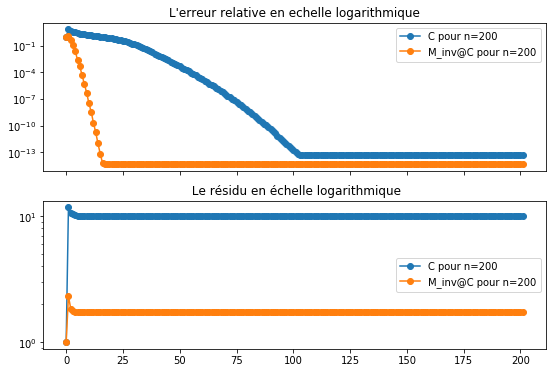

In [402]:
"""C et M_inv@C"""
fig,ax = plt.subplots(2,1,figsize=(9,6),sharex=True)
plot_C(Err_rel,Res_rel,"C pour n="+str(n),ax);
plot_C(Err_rel_M,Res_rel_M,"M_inv@C pour n="+str(n),ax);


In [403]:
"""C et M_inv@C"""
print("le conditionnement de C est =",np.linalg.cond(C))
print("\nle conditionnement de M_inv@C est =",np.linalg.cond(C_jac))

le conditionnement de C est = 160.90704910755184

le conditionnement de M_inv@C est = 3.2409851646203025


***Synthèse:***

Pour un n assez grand on a les tableaux suivants:

$$Pour: \, \, \, n= 20$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Préconditionnement} & Jacobi \,& Sans \\
\hline
\text{Temps (ms)} & 24&21 \\
\hline
\hline
\text{Conditionnement } & 3.24&17.34 \\
\hline
\end{array}
$$

$$Pour: \, \, \, n= 100$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Préconditionnement} & Jacobi \,& Sans \\
\hline
\text{Temps (ms)} & 393&383 \\
\hline
\hline
\text{Conditionnement } & 3.24&81.14 \\
\hline
\end{array}
$$

$$Pour: \, \, \, n= 200$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Préconditionnement} & Jacobi \,& Sans \\
\hline
\text{Temps (ms)} & 1750&1870 \\
\hline
\hline
\text{Conditionnement } & 3.24&160.90 \\
\hline
\end{array}
$$

***Commentaire:***

Le temps est quasi identique mais le résultat avec préconditionnement de `Jacobi` donne de meilleur résultat en moins d'itérations possible. Cependant le résultat n'est pas satisfaisant pour les deux car le résidus est trés grand donc il faut utiliser un autre préconditionnement en l'occurence `ILU` voir en dessous. Ceci est évident car le `Cond()` doit être proche de 1 ce qui n'est pas le cas pour les deux cas mais le plus en se rapproche de 1 le mieux on converge vers la solution.

## Question 8:

In [404]:
def matrices_D(n):
    D= np.diag(2*np.arange(n)) - np.diag(np.ones(n-1),1) - np.diag(np.ones(n-1),-1)

    xexact = np.ones(n)
    b= D@xexact
    M = np.diag(2+np.arange(n))
    M_inv = np.linalg.pinv(M)
    
    return M_inv,D,b,xexact

n=200
M_inv,D,b,xexact = matrices_D(n)
#print("\nC=\n",D)
#print("\nM_inv=\n",M_inv)
#print("\n b=\n",b)
#print("\n xexact=\n",xexact)

In [405]:
%%time
"""D"""
X,Err_rel,Res_rel=GMRES(D,b,xexact)

Wall time: 2.08 s


In [406]:
D_jac=M_inv@D
b_jac=M_inv@b

In [407]:
%%time
"""M_inv@C"""
X_M,Err_rel_M,Res_rel_M=GMRES(D_jac,b_jac,xexact)

Wall time: 1.84 s


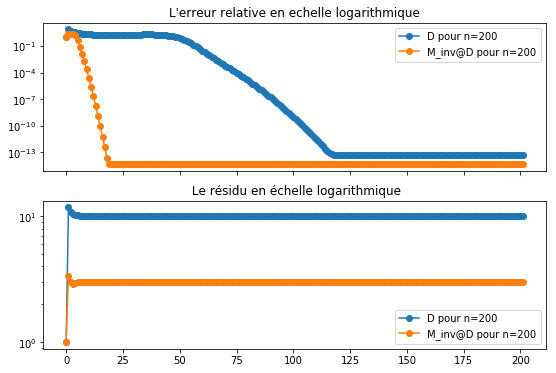

In [408]:
"""C et M_inv@C"""
fig,ax = plt.subplots(2,1,figsize=(9,6),sharex=True)
plot_C(Err_rel,Res_rel,"D pour n="+str(n),ax);
plot_C(Err_rel_M,Res_rel_M,"M_inv@D pour n="+str(n),ax);

In [409]:
"""D et M_inv@D"""
print("le conditionnement de D est =",np.linalg.cond(D))
print("\nle conditionnement de M_inv@D est =",np.linalg.cond(D_jac))

le conditionnement de D est = 883.7359104392477

le conditionnement de M_inv@D est = 9.873309620374771


***Synthèse:***

Pour un n assez grand on a les tableaux suivants:

$$Pour: \, \, \, n= 20$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Préconditionnement} & Jacobi \,& Sans \\
\hline
\text{Temps (ms)} & 22&21 \\
\hline
\hline
\text{Conditionnement } & 9.68&85.440 \\
\hline
\end{array}
$$

$$Pour: \, \, \, n= 100$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Préconditionnement} & Jacobi \,& Sans \\
\hline
\text{Temps (ms)} & 362&373 \\
\hline
\hline
\text{Conditionnement } & 9.83&160.90 \\
\hline
\end{array}
$$


$$Pour: \, \, \, n= 200$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Préconditionnement} & Jacobi \,& Sans \\
\hline
\text{Temps (ms)} & 1740&1890 \\
\hline
\hline
\text{Conditionnement } & 9.89&883.73 \\
\hline
\end{array}
$$



***Conclusion:***

* Plus le conditionnement est proche de 1 plus on a une convergeance vers le résultat. 
* Le conditionnement ne varie varie avec n.
* le temps de calcule ne varie pas avec n sans ou avec preconditionnement.
* Le conditionnement donne une idée sur la variance des elements de la diagonales autour de 1.

## Question 9:

In [459]:
def gradient_conjugue_precond(A,b,M,xexact,eps=eps):
     
    """Initialisation"""
    cpt = 0 #pour calculer le nombre d'iteration
    n=A.shape[0]
    x=np.zeros_like(b)
    #print("\n------Solution initiale--------\nx_0=\n",x)
    r0 = b-A@x # pour eviter d'avoir des copie de pointeur
    r_init = b-A@x
    #print("check=",r0)
    """trouver z0"""
    z0 = M.solve(r0) #solve() est une methode de l'objet `SuperLU`
    d0 = z0
    
    err_rel = sp.linalg.norm(xexact-x)/ sp.linalg.norm(xexact)
    res_rel = sp.linalg.norm(r0)/ sp.linalg.norm(r0)
    
    Err_rel = np.array([err_rel])
    Res_rel = np.array([res_rel])
    

    r = r_init
    z = z0
    d = d0
    #on pourra essayer pour while((res_rel > eps)and (cpt<n*n)) mais le résultat et pareil!
    while ((res_rel > eps)and (cpt<n)):
        
        """etape k"""
        r_k = r #pour pouvoir l'utiliser ultérieurement en bas
        z_k = z #pour pouvoir l'utiliser ultérieurement en bas
        d_k = d #pour pouvoir l'utiliser ultérieurement en bas
        
        """etape k+1"""
        s = (r@z)/((A@d)@d)
        x += s*d
        
        r -= s*A@d
        #print("check",sp.linalg.norm(r))
        
        """trouver z"""
        z = M.solve(r) #solve() est une methode de l'objet `SuperLU`
        
        beta = (r@z)/(r_k@z_k)
        d = z + beta*d_k 
        
        err_rel = sp.linalg.norm(xexact-x)/ sp.linalg.norm(xexact) 
        res_rel = sp.linalg.norm(r)/ sp.linalg.norm(r0)
        #print("check",sp.linalg.norm(r0))
        
        cpt+=1
        #print("\n------Solution pour k="+str(cpt)+"------\nx_"+str(cpt)+"=\n",x.T)
        
        Err_rel = np.append(Err_rel,err_rel)
        Res_rel = np.append(Res_rel,res_rel)
    print("\n------Solution obtenue aprés k="+str(cpt)+" iterations------\n \n")
   
    return x,Err_rel,Res_rel

## Question 10:

In [495]:
"""test"""
def gradient_conjugue_precond_test(d):
    
    n = d*d
    B= spsp.diags([[4.]*n,[-1]*(n-1),[-1]*(n-1),[-1]*(n-d),[-1]*(n-d)],
                  [0,1,-1,d,-d])
    B = spsp.csc_matrix(B) #to.csr() n'a pas marché même dans le TP d'avant
    b =  2*np.ones(n).astype(np.float64)
    """solution exacte scipy"""
    xexact = np.array(spsolve(B,b))
    M = spsp.linalg.splu(B)
    
    #print(xexact) 
    return M,B,b,xexact
d=15
#d=10
#d=5
M,B,b,xexact = gradient_conjugue_precond_test(d)
A,b,xexact = gradient_conjugue_test(d)
#print("\nB=\n",B)
#print("\nM=\n",M)
#print("\n b=\n",b)
#print("\n xexact=\n",xexact)

In [491]:
15*15

225

In [492]:
%%time
"""le gradient conjugué préconditionné ILU"""
x,Err_rel_LU,Res_rel_LU = gradient_conjugue_precond(B,b,M,xexact,10**(-24))#pour avoir plus d'iteration pour la comparaison eps=10**-24


------Solution obtenue aprés k=225 iterations------
 

Wall time: 96.9 ms


In [493]:
%%time
"""le gradient conjugué sans préconditionnement"""
x,Err_rel,Res_rel= gradient_conjugue(A,b,xexact)


------Solution obtenue aprés k=225 iterations------
 

Wall time: 92.9 ms


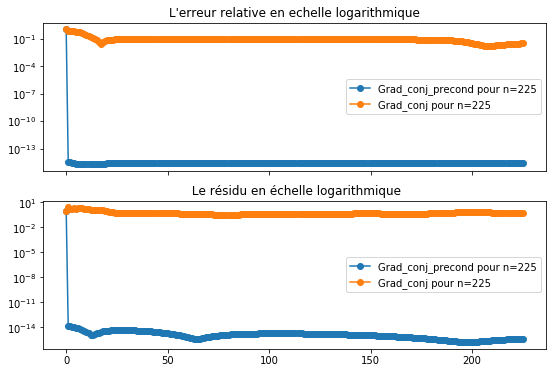

In [494]:
fig,ax = plt.subplots(2,1,figsize=(9,6),sharex=True);
ax = plot_C(Err_rel_LU,Res_rel_LU,"Grad_conj_precond pour n="+str(d*d),ax);
plot_C(Err_rel,Res_rel,"Grad_conj pour n="+str(d*d),ax);
#ax[1].set_xlim(0,2);

***Commentaire:***
La convergeance est immédiate `1 itération` pour une matrice $\mathbf M_{100,100}(\mathbb R)$ rapidement `3ms` et avec une trés bonne précision. On a augmenté la précision histoire d'avoir plus d'iteration pour comparer les courbes en dessus.

***Synthèse:***
Pour un n assez grand on a les tableaux suivants:

$$Pour: \, \, \, n= 25$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Algorithme} & Gradient \, Conjugue_{preconditionné ILU} \,& Gradient \,conjugue \\
\hline
\hline
\text{Précision } & 10^{-24}&10^{-4} \\
\hline
\text{Temps (ms)} & 20&17 \\
\hline
\end{array}
$$

$$Pour: \, \, \, n= 100$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Algorithme} & Gradient \, Conjugue_{preconditionné ILU} \,& Gradient \,conjugue \\
\hline
\hline
\text{Précision } & 10^{-24}&10^{-4} \\
\hline
\text{Temps (ms)} & 48&43 \\
\hline
\end{array}
$$


$$Pour: \, \, \, n= 225$$
$$
\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Algorithme} & Gradient \, Conjugue_{preconditionné ILU} \,& Gradient \,conjugue \\
\hline
\hline
\text{Précision } & 10^{-24}&10^{-4} \\
\hline
\text{Temps (ms)} & 92&95 \\
\hline
\end{array}
$$

***Conclusion:***
* Pour quasiment le meme temps de calcule le `gradient conjugué preconditionné ILU` il fournie une précision remarquable.
* Pour une précision comparable à celle `gradient conjugué` le`gradient conjugué preconditionné ILU` converge en une iteration et dans un temps de `3ms`.
* Les deux methodes sont rapides puisqu'ils sont adapté avec les formats creuses.